# GWAS of UHS2–3 combined with UHS4
**Author:** Jesse Marks <br>
**GitHub Issue**: [# 147 ](https://github.com/RTIInternational/bioinformatics/issues/147)

**Description:** 

The starting point (input data) for this pipeline is after the quality control (QC) of the observed genotype data. The QC genotype data should be oriented on the GRGh37 plus strand. When multiple data sets are to be merged for imputation, the intersection set of variants will be used for imputation; this is based on the finding from [Johnson et al.](https://link.springer.com/article/10.1007/s00439-013-1266-7). 

**Software and tools** <br>
The software and tools used for processing these data are:
* [Michigan Imputation Server](https://imputationserver.sph.umich.edu/index.html) (MIS)
* [Amazon Web Services (AWS) - Cloud Computing Services](https://aws.amazon.com/)
    * Linux AMI
* [PLINK v1.90 beta 4.10](https://www.cog-genomics.org/plink/)
* [bgzip](http://www.htslib.org/doc/tabix.html)
* [BCF Tools](http://www.htslib.org/doc/bcftools.html)
* Windows 10 with [Cygwin](https://cygwin.com/) installed
* GNU bash version 4.2.46

**Pre-Imputation Stats Summary**

| Data Set      | Initial Variants (Post-QC) | Variants Post-Filtering  | Intersection     |
|---------------|----------------------------|--------------------------|------------------|
|               |                            |                          |                  |
|               |                            |                          |                  |


**Phenotype Files**
* `s3://rti-heroin/ngc_uhs2_uhs3_fou/data/phenotype`
* `s3://rti-shared/gwas/uhs4/data/box_cox_totopioid_tot_30d/0001/phenotype/`

**Genotype Files**
* `s3://rti-hiv/rti-midas-data/studies/hiv/observed/final/uhs2.{aa,ea}.{bed,bim,fam}.gz`
* `s3://rti-hiv/rti-midas-data/studies/hiv/observed/final/uhs3.{aa,ea}.V1-2.{bed,bim,fam}.gz`
* `s3://rti-hiv/rti-midas-data/studies/hiv/observed/final/uhs3.aa.V1-3.{bed,bim,fam}.gz`
* `s3://rti-shared/rti-midas-data/studies/uhs4/observed/genotypes/final/uhs4.merged2.{aa,ea}.{bed,bim,fam}.gz`

Note that the UHS3 was genotyped on two different versions of the same chip: V1–2 and V1–3. We will use the data that was QC'ed separately for each chip.

## Impute Genotype Data
### Create Directory Stucture & Download Data
The following section needs to be modified each time to reflect:
* where the genotype data (post-QC) are stored
* where the base directory for the pre-imputation data processing will be
* the study or studies involved
* the ancesty group(s) involved
* the data to be processed (all_chr or chr23)

In [ ]:
#cd /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing

# parameters 
base_dir=/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing # DO NOT end in forward slash
ancestry_list="ea aa" # space delimited Ex. "ea aa ha"
study_list="uhs2 uhs3_v1-2 uhs3_v1-3 uhs4" # space delimited 
#base_name="chr_all" # chr_all chr23 

# create directory structure
mkdir -p ${base_dir}/{intersect,1000g,impute_prep}
for study in ${study_list};do
    mkdir -p ${base_dir}/${study}/strand_check
    for ancestry in ${ancestry_list};do
        mkdir -p ${base_dir}/${study}/genotype/${ancestry}
    done
done


## copy post-qc genotype data to correct directory
## AND REMAME TO CORRECT NAMING SCHEMA <study_ancestry.$extension> 
## also unzip the Plink files

#/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/genotype/{ea,aa}
#/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/genotype/{ea,aa}
#/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/genotype/{ea,aa}
#/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/genotype/{ea,aa}

### GRCh37 strand and allele discordance check
#### MAF for study data (all chromosomes)

In [ ]:
# Write out the MAF report
for study in ${study_list}; do
    for ancestry in ${ancestry_list}; do
        docker run -v "${base_dir}/$study/:/data/" rticode/plink:1.9 plink \
            --bfile /data/genotype/$ancestry/${study}_${ancestry} \
            --freq \
            --out /data/strand_check/${ancestry}
    done
done


# Get list of variants from all studies
studies=($study_list)  #studies=(uhs1 uhs2 uhs3_v1-2 uhs3_v1-3 uhs4) # array of study names
num=${#studies[@]}

## Get intersection set
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/${studies[$i]}/genotype/$ancestry/*bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry: ${study_list}...\n"
    cat ${bim_files[@]}| cut -f2 | sort |  uniq -c | awk -v num=$num '$1 == num {print $2}' \
        > ${base_dir}/intersect/${ancestry}_variant_intersection.txt
    wc -l ${base_dir}/intersect/${ancestry}_variant_intersection.txt
done 

```
1410989 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/ea_variant_intersection.txt
1100949 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/aa_variant_intersection.txt
```

#### MAF for 1000G
The current setup requires the 1000G MAF for autosomes and chrX to be processed separately. This pipeline is also currently set up to handle EUR and AFR populations. 
##### Autosomes
Get 1000G MAF for chromosomes 1&ndash;22 (autosomes).

In [ ]:
# Calculate autosome MAFs for 1000G populations
for ancestry in ${ancestry_list};do

    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_MAF \
            --script_prefix ${base_dir}/1000g/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out ${base_dir}/1000g/${pop}_chr${chr}.maf \
                --extract ${base_dir}/intersect/${ancestry}_variant_intersection.txt \
                --keep_groups ${pop}
    done
done

##### chrX 
Get 1000G MAF for chromosome 23 (chrX).

In [ ]:
chr=23
for ancestry in ${ancestry_list};do

    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_23_MAF \
        --script_prefix ${base_dir}/1000g/${pop}_chr${chr}.maf \
        --mem 6.8 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr $chr \
            --out ${base_dir}/1000g/${pop}_chr${chr}.maf \
            --extract ${base_dir}/intersect/${ancestry}_variant_intersection.txt \
            --keep_groups ${pop}
done

#### Merge 1000G chromosomes
Only need to perform this if there were multiple chromosomes for which the MAF was calculated.

In [ ]:
# Merge per chr MAFs for each 1000G population
for ancestry in ${ancestry_list};do
    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    head -n1 ${base_dir}/1000g/${pop}_chr1.maf > ${base_dir}/1000g/${pop}_chr_all.maf
    for chr in {1..23}; do
            tail -q -n +2 ${base_dir}/1000g/${pop}_chr${chr}.maf >> \
                ${base_dir}/1000g/${pop}_chr_all.maf
    done
done

#### Autosome Discordant Check

In [ ]:
# Run discordance checks for each ancestry group
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        if [ $ancestry = "ea" ]; then
            pop="EUR"
        elif [ $ancestry == "ha" ]; then
            pop="AMR"
        else
            pop="AFR"
        fi

       /shared/bioinformatics/software/scripts/qsub_job.sh \
           --job_name ${ancestry}_${study}_crosscheck \
           --script_prefix ${base_dir}/$study/strand_check/${ancestry}_allele_discordance_check \
           --mem 6 \
           --nslots 3 \
           --priority 0 \
           --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
               --study_bim_file ${base_dir}/${study}/genotype/${ancestry}/*bim
               --study_frq_file ${base_dir}/${study}/strand_check/${ancestry}.frq
               --ref_maf_file ${base_dir}/1000g/${pop}_chr_all.maf
               --out_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance"
    done
done

#### chrX Discordant Check
Run this cell below if you are only processing chrX.

In [ ]:
#for study in ${study_list}; do
#    for ancestry in ${ancestry_list};do
#        if [ $ancestry = "ea" ]; then
#            pop=EUR
#    elif [ $ancestry == "ha" ]; then
#        pop="AMR"
#        else
#            pop=AFR
#        fi
#
#        # chr23 discordance check
#        /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name ${ancestry}_${study}_crosscheck \
#            --script_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance_check \
#            --mem 6.8 \
#            --nslots 1 \
#            --priority 0 \
#            --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
#                --study_bim_file ${base_dir}/data/${study}/genotype/${ancestry}/*bim
#                --study_frq_file ${base_dir}/${study}/strand_check/${ancestry}_chr23.frq
#                --ref_maf_file ${base_dir}/1000g/${pop}_chr23.maf
#                --out_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance"
#    done
#done

#### Resolving allele discordances
The allele discordances will be resolved by
* Flipping allele discordances that are fixed by flipping
* Removing SNPs with discordant names
* Removing SNPs with discordant positions
* Removing allele discordances that are not resolved by flipping
* Removing alleles with large deviations from the reference population allele frequencies

**Note**: We could flip the SNPs that are in the snps.flip file we create here, however we are going to opt not to this time because we found that for this case flipping did not actually resolve the issue because most likely they were monomorphic variants.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        echo -e "\n===============\nProcessing ${study}_${ancestry}\n"
        echo "Making remove list"
        cat <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.at_cg_snps_freq_diff_gt_0.2 | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_names | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_positions | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip | tail -n +2) | \
              sort -u > ${base_dir}/${study}/strand_check/${ancestry}_snps.remove

        # Create flip list
        echo "Making flip list"
        comm -23 <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles | tail -n +2 | sort -u) \
                 <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2 | sort -u) \
                 > ${base_dir}/${study}/strand_check/${ancestry}_snps.flip

        # Apply filters
        docker run -v ${base_dir}/$study/:/data/ rticode/plink:1.9 plink \
            --bfile  /data/genotype/${ancestry}/${study}_${ancestry} \
            --exclude /data/strand_check/${ancestry}_snps.remove \
            --make-bed \
            --out     /data/${ancestry}_filtered
    done
done

wc -l $base_dir/*/*filtered.bim
wc -l $base_dir/*/strand_check/*remove
wc -l $base_dir/*/strand_check/*snps.flip

```
  1395192 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/aa_filtered.bim
  1819914 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/ea_filtered.bim
  1798198 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/aa_filtered.bim
  1840998 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/ea_filtered.bim
  1773572 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/aa_filtered.bim
  1810408 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/ea_filtered.bim
  1878289 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/aa_filtered.bim
  2073567 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/ea_filtered.bim
 14390138 total
[ec2-user@ip-172-31-20-229 uhs2]$ wc -l $base_dir/*/strand_check/*remove
    660 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/strand_check/aa_snps.remove
    967 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/strand_check/ea_snps.remove
  47727 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/strand_check/aa_snps.remove
  83760 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/strand_check/ea_snps.remove
  33147 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/strand_check/aa_snps.remove
  58202 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/strand_check/ea_snps.remove
     46 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/strand_check/aa_snps.remove
     51 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/strand_check/ea_snps.remove
 224560 total
[ec2-user@ip-172-31-20-229 uhs2]$ wc -l $base_dir/*/strand_check/*snps.flip
    67 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/strand_check/aa_snps.flip
    78 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/strand_check/ea_snps.flip
  1921 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/strand_check/aa_snps.flip
  2692 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/strand_check/ea_snps.flip
  1516 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/strand_check/aa_snps.flip
  2074 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/strand_check/ea_snps.flip
    27 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/strand_check/aa_snps.flip
    35 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/strand_check/ea_snps.flip

[ec2-user@ip-172-31-20-229 uhs2]$ wc -l $base_dir/*/strand_check/*remove
    660 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/strand_check/aa_snps.remove
    967 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/strand_check/ea_snps.remove
  47727 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/strand_check/aa_snps.remove
  83760 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/strand_check/ea_snps.remove
  33147 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/strand_check/aa_snps.remove
  58202 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/strand_check/ea_snps.remove
     46 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/strand_check/aa_snps.remove
     51 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/strand_check/ea_snps.remove
```

#### Remove monomorphic variants
Monomorphic variants prevent MIS from accepting the genotype data. In this case, an arbitrarily small MAF is set that is smaller than the lower bound for these data.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        docker run -v "${base_dir}/$study/:/data/" rticode/plink:1.9 plink \
            --bfile /data/${ancestry}_filtered \
            --maf 0.000001 \
            --make-bed \
            --out /data/${ancestry}_filtered_mono
    done
done

wc -l $base_dir/*/*mono.bim

```
  1324176 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/aa_filtered_mono.bim
  1453036 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs2/ea_filtered_mono.bim
  1581954 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/aa_filtered_mono.bim
  1198874 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-2/ea_filtered_mono.bim
  1569221 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/aa_filtered_mono.bim
  1195772 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs3_v1-3/ea_filtered_mono.bim
  1802905 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/aa_filtered_mono.bim
  1782512 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/uhs4/ea_filtered_mono.bim
```

### Snp Intersection
Only perform if merging datasets. 
Note that the intersection sets were created in an earlier step, however a new set needs to be created since there were subsequent filtering steps applied since the earlier step.

In [ ]:
# Get list of variants from all studies
studies=($study_list)  #studies=(uhs2 uhs3_v1-2 uhs3_v1-3 uhs4) # array of study names
num=${#studies[@]}

## Get intersection set
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/${studies[$i]}/${ancestry}_filtered_mono.bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry: ${study_list}...\n"
    cat ${bim_files[@]}| cut -f2 | sort |  uniq -c | awk -v num=$num '$1 == num {print $2}' \
        > ${base_dir}/intersect/${ancestry}_variant_intersection2.txt
    wc -l ${base_dir}/intersect/${ancestry}_variant_intersection2.txt
done 




# Make new PLINK binary file sets
for ancestry in ${ancestry_list};do
    for study in ${studies[@]}; do
        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
            --bfile /data/$study/${ancestry}_filtered_mono \
            --extract /data/intersect/${ancestry}_variant_intersection2.txt \
            --make-bed \
            --out /data/intersect/${study}_${ancestry}_filtered_snp_intersection
    done
done
    
ww $base_dir/intersect/*section.txt

```
794168 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/ea_variant_intersection2.txt
973271 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/aa_variant_intersection2.txt
```

#### Merge test
As a final check to confirm that our data sets are all compatible, a PLINK file set merge is conducted. If any issues persist then an error will be raised. 

Only run this section if merging data.

In [ ]:
for ancestry in $ancestry_list; do
    echo "Creating $ancestry merge-list"
    truncate -s 0 ${base_dir}/intersect/${ancestry}_merge_list.txt
    for study in $study_list; do
        echo /data/${study}_${ancestry}_filtered_snp_intersection >>\
        ${base_dir}/intersect/${ancestry}_merge_list.txt
    done
    
# Merge file sets
    echo -e "\n\n======== ${ancestry} ========\n\n"
    docker run -v "${base_dir}/intersect:/data/" rticode/plink:1.9 plink \
        --merge-list /data/${ancestry}_merge_list.txt \
        --make-bed \
        --out /data/${ancestry}_studies_merged
done

wc -l $base_dir/intersect/*merged*bim

##### If errors

In [ ]:
## if errors were thrown, remove missnps and run again
# Merge file sets
for ancestry in ${ancestry_list};do
    for study in ${studies[@]}; do
        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
            --bfile /data/$study/${ancestry}_filtered_mono \
            --extract /data/intersect/${ancestry}_variant_intersection2.txt \
            --exclude /data/intersect/${ancestry}_studies_merged-merge.missnp \
            --make-bed \
            --out /data/intersect/${study}_${ancestry}_filtered_snp_intersection
    done
done
    

for ancestry in $ancestry_list; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    docker run -v "${base_dir}/intersect:/data/" rticode/plink:1.9 plink \
        --merge-list /data/${ancestry}_merge_list.txt \
        --make-bed \
        --out /data/${ancestry}_studies_merged
done

wc -l $base_dir/intersect/*merged*bim

```
  973215 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/aa_studies_merged.bim
  794121 /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/ea_studies_merged.bim
```

### Imputation preparation for Michigan Imputation Server
Visit the [MIS Getting Started Webpage](https://imputationserver.sph.umich.edu/start.html#!pages/help) for more information about the preparing the data for upload to MIS.

#### Remove individuals missing whole chromsome
Remove any individual missing, essentially, an entire chromosome. Then convert the data to VCF format.

##### If NO merging was performed
(i.e. only one study being processed)

In [ ]:
## Split by chr and remove any individuals with missing data for whole chr
#for ancestry in $ancestry_list; do
#    for chr in {1..23}; do
#        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
#            --bfile /data/$study/${ancestry}_filtered_mono \
#            --chr ${chr} \
#            --mind 0.99 \
#            --make-bed \
#            --out /data/impute_prep/${ancestry}_chr${chr}_for_phasing 
#    done
#done > ${base_dir}/impute_prep/chr_splitting.log 
#
#
### look through log files to determine if any subjects were removed
#for ancestry in $ancestry_list; do
#    grep removed $base_dir/impute_prep/$ancestry*log |
#        perl -lne '/(\d+)(\speople)/;
#             $mycount += $1; 
#             print $mycount if eof'  > $base_dir/impute_prep/$ancestry.removed
#    any_removed=$(cat $base_dir/impute_prep/$ancestry.removed)
#    if [ "$any_removed" == 0 ]; then
#        echo "No $ancestry subjects removed"
#    else
#        echo "Some $ancestry subjects removed"
#    fi
#done

##### If merging was performed

In [ ]:
## Split by chr and remove any individuals with missing data for whole chr
for chr in {1..23}; do 
    for ancestry in $ancestry_list;do
        docker run -v "${base_dir}:/data/" rticode/plink:1.9 plink \
            --bfile /data/intersect/${ancestry}_studies_merged \
            --chr ${chr} \
            --mind 0.99 \
            --make-bed \
            --out /data/impute_prep/${ancestry}_chr${chr}_for_phasing
    done > ${base_dir}/impute_prep/chr_splitting.log 
done


## look through log files to determine if any subjects were removed
for ancestry in $ancestry_list; do
    grep removed $base_dir/impute_prep/$ancestry*log |
        perl -lne '/(\d+)(\speople)/;
             $mycount += $1; 
             print $mycount if eof'  > $base_dir/impute_prep/$ancestry.removed
    any_removed=$(cat $base_dir/impute_prep/$ancestry.removed)
    if [ "$any_removed" == 0 ]; then
        echo "No $ancestry subjects removed"
    else
        echo "Some $ancestry subjects removed"
    fi
done

```
No ea subjects removed
No aa subjects removed
```

#### Convert to VCF

In [ ]:
for ancestry in ${ancestry_list}; do
    mkdir -p ${base_dir}/impute_prep/${ancestry}
    for chr in {1..23}; do
        docker run -v "${base_dir}/impute_prep/:/data/" rticode/plink:1.9 plink \
            --bfile /data/${ancestry}_chr${chr}_for_phasing \
            --output-chr M \
            --set-hh-missing \
            --recode vcf bgz \
            --out /data/$ancestry/${ancestry}_chr${chr}_final
    done
done

Transfer the *.vcf.gz files to local machine (per chromosome) and then upload to MIS.

### Upload to Michigan Imputation Server (MIS)
Transfer the `*.vcf` files to local machine (per chromosome) and then upload to MIS.

**Uploading parameters** 
These are the parameters that were selected on MIS:

__Name__: UHS2-4 EUR

__imputatation__: minimac4

__Reference Panel__ 1000G Phase 3 v5

__Input Files__ File Upload <br>

* Select Files - select VCF files that were downloaded to local machine from cloud. <br>

__Phasing__: Eagle2.4

__Population__: EUR

__Mode__: Quality Control & Imputation

* I will not attempt to re-identify or contact research participants.
* I will report any inadvertent data release, security breach or other data management incident of which I become aware.

### Download Imputed Data from MIS
First Download the data form the Michigan Imputation Server by clicking on the link provided in the email they send out to alert you that your data has finished. Here you will find commands for downloading the data.

In [ ]:
ancestry=ea
study=uhs234
passW="WdXIdjK6y5Xba"
cd /shared/jmarks/heroin/uhs2-4/genotype/imputed/final/$ancestry


# download files
####################################################################################################
####################################################################################################

# QC-report
curl -sL https://imputationserver.sph.umich.edu/get/1773488/677c2138d82f8bf4af22aef1fda85dc0 | bash
# Logs
curl -sL https://imputationserver.sph.umich.edu/get/1773495/f1f281cae8708013c4da18b6cd1af757 | bash
# SNP Statistics
curl -sL https://imputationserver.sph.umich.edu/get/1773492/3d47726f3dbf1f7b7879de3a62fb3c58 | bash
# Imputation Results
curl -sL https://imputationserver.sph.umich.edu/get/1773494/6b2cad9fb5ae71037c5952fd805e4c6 | bash
####################################################################################################
####################################################################################################

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry.$file \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 3 \
        --priority 0 \
        --program unzip -P $passW $file 
done 

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip

# upload to s3
aws s3 sync . s3://rti-hiv/uhs234/data/genotype/imputed/$ancestry --quiet &

In [ ]:
ancestry=aa
study=uhs234
passW="4EjN7YJqJttuc5"
cd /shared/jmarks/heroin/uhs2-4/genotype/imputed/final/$ancestry


# download.file
####################################################################################################
####################################################################################################

# QC-report
curl -sL https://imputationserver.sph.umich.edu/get/1773593/b9d8178fc0496d1db0016a88ba654573 | bash
# Logs
curl -sL https://imputationserver.sph.umich.edu/get/1773600/b83e05f07add3e50992eca5007d6f5b5 | bash
# SNP Statistics
curl -sL https://imputationserver.sph.umich.edu/get/1773597/7a53fbc310527c849e8733207f3c1810 | bash
# Imputation Results
curl -sL https://imputationserver.sph.umich.edu/get/1773599/191f0c269339a69ccd91eeb7869d0061 | bash

####################################################################################################
####################################################################################################

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry.$file \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 3 \
        --priority 0 \
        --program unzip -P $passW $file 
done 

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip

# upload to s3
aws s3 sync . s3://rti-heroin/shared_data/post_qc/uhs234/genotype/array/imputed/mis_eagle2/1000g_p3/afr/ 

## Phenotype file construction
### Data wrangling
Create a phenotype table filtered by the subjects available in the genotype data. Since the GWAS for UHS2—3 and the GWAS for UHS4 were already ran, we will use the phenotype files already available and combine them to make a new table.

variables of interest:
* `sex`
* `age`
* `genotype PCs`

The merged genotype files are located at:
* `/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/{aa,ea}_studies_merged.{bed,bim,fam}`


The FOU phenotype is already converted to z-scores.
```
 wc -l aa_studies_merged.fam
2017 aa_studies_merged.fam

wc -l ea_studies_merged.fam
1894 ea_studies_merged.fam
```

In [ ]:
## create merged phenotype table
cd /shared/jmarks/heroin/uhs2-4/phenotype/processing/uhs2-3

paste <(cut -f1,2,5,6 uhs2-3_NGCW1_AFR_cov.ped) \
    <(cut -f6 uhs2-3_NGCW1_AFR_phen.ped)  >\
    ../uhs23_afr_phenotype_table.txt # ID, sex, age
paste <(cut -f1,2,5,6 uhs2-3_NGCW1_EUR_cov.ped) \
    <(cut -f6 uhs2-3_NGCW1_EUR_phen.ped)  >\
    ../uhs23_eur_phenotype_table.txt


cd /shared/jmarks/heroin/uhs2-4/phenotype/processing/uhs4
# splitting the fid in half. Also fid and iid are the same
awk 'BEGIN{OFS="\t"} NR==1{print $1,$2,$5,$7,$6} 
    {a=substr($1, 1, length($1)/2)} NR>=2{print a,a,$5,$7,$6}' \
    afr/uhs4_box_cox_totopioid_tot_30d.tsv > ../uhs4_afr_phenotype_table.txt # fid, iid, sex, age, totopioid_tot_30d
awk 'BEGIN{OFS="\t"} NR==1{print $1,$2,$5,$7,$6} 
    {a=substr($1, 1, length($1)/2)} NR>=2{print a,a,$5,$7,$6}' \
    eur/uhs4_box_cox_totopioid_tot_30d.tsv > ../uhs4_eur_phenotype_table.txt

# merge UHS2–3 and UHS4
cat uhs23_afr_phenotype_table.txt <(tail -n +2 uhs4_afr_phenotype_table.txt) >\
    uhs234_afr_phenotype_table.txt
cat uhs23_eur_phenotype_table.txt <(tail -n +2 uhs4_eur_phenotype_table.txt) >\
    uhs234_eur_phenotype_table.txt

```
wc -l uhs234_afr_phenotype_table.txt
1774 uhs234_afr_phenotype_table.txt

wc -l uhs234_eur_phenotype_table.txt
1841 uhs234_eur_phenotype_table.txt
```

In [ ]:
## filter genotype files down to subjects in phenotype files
afr_gen=/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/aa_studies_merged.fam
eur_gen=/shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect/ea_studies_merged.fam

mkdir /shared/jmarks/heroin/uhs2-4/phenotype/processing/eig 

tail -n +2 uhs234_afr_phenotype_table.txt  | awk '{print $1, $1}' > uhs234_afr_keep_ids.txt
tail -n +2 uhs234_eur_phenotype_table.txt  | awk '{print $1, $1}' > uhs234_eur_keep_ids.txt


#awk 'FNR==NR{map[$1]=$1; next} 
#    { if ($1 in map) 
#    {print $0}}' uhs234_afr_keep_ids.txt ${afr_gen}  > uhs234_afr_filtered.fam
#
#awk 'FNR==NR{map[$1]=$1; next} 
#    { if ($1 in map) 
#    {print $0}}' uhs234_eur_keep_ids.txt ${eur_gen}  > uhs234_eur_filtered.fam


# create updated plink filesets for PCA
docker run -v /shared/jmarks/heroin/uhs2-4/phenotype/processing:/data/ \
           -v /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect:/data/intersect \
    rticode/plink:1.9 plink \
        --bfile /data/intersect/aa_studies_merged \
        --keep /data/uhs234_afr_keep_ids.txt \
        --make-bed \
        --out /data/eig/uhs234_afr_genotypes

docker run -v /shared/jmarks/heroin/uhs2-4/phenotype/processing:/data/ \
           -v /shared/jmarks/heroin/uhs2-4/genotype/imputed/processing/intersect:/data/intersect \
    rticode/plink:1.9 plink \
        --bfile /data/intersect/ea_studies_merged \
        --keep /data/uhs234_eur_keep_ids.txt \
        --make-bed \
        --out /data/eig/uhs234_eur_genotypes

```
  1711 uhs234_afr_filtered.fam
  1563 uhs234_eur_filtered.fam
```

In [ ]:
## filter phenotype down to subjects with both phenotype & genotype data
cd /shared/jmarks/heroin/uhs2-4/phenotype/processing/

for an in {afr,eur}; do
    awk 'NR==FNR{map[$1]=$1; next} FNR==1 {print $0} {
        if ($1 in map){
            {print $0}
        }
        }' eig/uhs234_${an}_genotypes.fam uhs234_${an}_phenotype_table.txt >\
        uhs234_${an}_phenotype_table_filtered.txt

done

### PCA (eigenstrat)

In [ ]:
#!/bin/bash

## Set global variables ##
anlist="afr eur" # Ex. "afr" or "afr eur"
study="uhs234"
procD="/shared/jmarks/heroin/uhs2-4/phenotype/processing"  # phenotype processing directory
eig="$procD/eig" # do not alter
mkdir -p $eig/results # do not alter


## Genotype Data should be in the directory $eig
## The genotype data names should be of the form: ${study}_${an}_genotype.{bed,bim,fam}. For Example:
## uhs234_afr_genotypes.bed, uhs234_afr_genotypes.bim, uhs234_afr_genotypes.fam

## The FAM file should have case control information in column 6 if applicable

# Do not edit below this line
################################################################################
################################################################################

## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/${study}_${an}_genotypes.bim > $eig/${study}_${an}_genotypes_high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${study}_${an}_genotypes \
        --exclude $eig/${study}_${an}_genotypes_high_ld_regions.remove \
        --make-bed \
        --out $eig/${study}_${an}_genotypes_high_ld_regions_removed
done

## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/${study}_${an}_genotypes_high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

## Merge *prune.in files ##
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${study}_${an}_genotypes_high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/${study}_${an}_genotypes_ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs ##
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/${study}_${an}_genotypes_ld_pruned.fam \
        > $eig/${study}_${an}_genotypes_ld_pruned_renamed.fam

    ## Rename BIM file IDs ##
    awk '{$2="ID_"NR; print $0}' $eig/${study}_${an}_genotypes_ld_pruned.bim \
        > $eig/${study}_${an}_genotypes_ld_pruned_renamed.bim
done

## run eigenstrat ##
for an in $anlist; do
    famfile="$eig/${study}_${an}_genotypes_ld_pruned_renamed.fam"
    bimfile="$eig/${study}_${an}_genotypes_ld_pruned_renamed.bim"
    bedfile="$eig/${study}_${an}_genotypes_ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${an}_ld_pruned.eval \
        -l $eig/results/${an}_ld_pruned.pca.log \
        -m 0
done

## Extract eigenvectors (top 10 PCs) ##
for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Next produce PCA plots

In [ ]:
## run the above pipeline
study=uhs234
procD=/shared/jmarks/heroin/uhs2-4/phenotype/processing
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.pca \
    --script_prefix $procD/eig/$study.pca \
    --priority 0 \
    --program bash $procD/${study}_pca.sh

### View PCs

In [ ]:
## Copy top PCs to local
cd /cygdrive/c/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs/uhs2-4/phenotype/processing
$ scp -i /home/jmarks/.ssh/gwas_rsa ec2-user@34.195.174.206:/shared/jmarks/heroin/uhs2-4/phenotype/processing/eig/results/*top10* .
$ scp -i /home/jmarks/.ssh/gwas_rsa ec2-user@34.195.174.206:/shared/jmarks/heroin/uhs2-4/phenotype/processing/eig/results/*evec .
$ scp -i /home/jmarks/.ssh/gwas_rsa ec2-user@34.195.174.206:/shared/jmarks/heroin/uhs2-4/phenotype/processing/uhs234_afr_phenotype_table_filtered.txt .
$ scp -i /home/jmarks/.ssh/gwas_rsa ec2-user@34.195.174.206:/shared/jmarks/heroin/uhs2-4/phenotype/processing/uhs234_eur_phenotype_table_filtered.txt .


In [8]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs/uhs2-4/phenotype/processing")
options(stringsAsFactors = F)
afr.evec <- read.table("afr_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
eur.evec <- read.table("eur_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
head(afr.evec[,1:5])
head(eur.evec[,1:5])

,V2,V3,V4,V5,V6
ID_1:ID_1,0.0249,0.0025,-0.0016,0.0125,-0.0066
ID_2:ID_2,0.0068,-0.0022,-0.0047,-0.0058,0.0062
ID_3:ID_3,0.0026,-0.0012,-0.0008,0.0006,-0.0066
ID_4:ID_4,0.0223,-0.0062,0.0104,-0.0026,-0.0132
ID_5:ID_5,0.0192,-0.0026,-0.0025,0.0009,0.0006
ID_6:ID_6,-0.0150,0.0026,-0.0052,-0.0057,-0.0076


,V2,V3,V4,V5,V6
ID_1:ID_1,0.0215,-0.0014,-0.0057,0.0052,0.0054
ID_2:ID_2,0.0005,0.0032,0.0061,-0.0141,-0.0020
ID_3:ID_3,0.0118,-0.0010,0.0063,-0.0064,0.0029
ID_4:ID_4,0.0068,0.0013,0.0008,-0.0056,0.0000
ID_5:ID_5,0.0125,-0.0050,0.0028,-0.0108,0.0020
ID_6:ID_6,0.0130,-0.0021,0.0021,-0.0102,0.0002


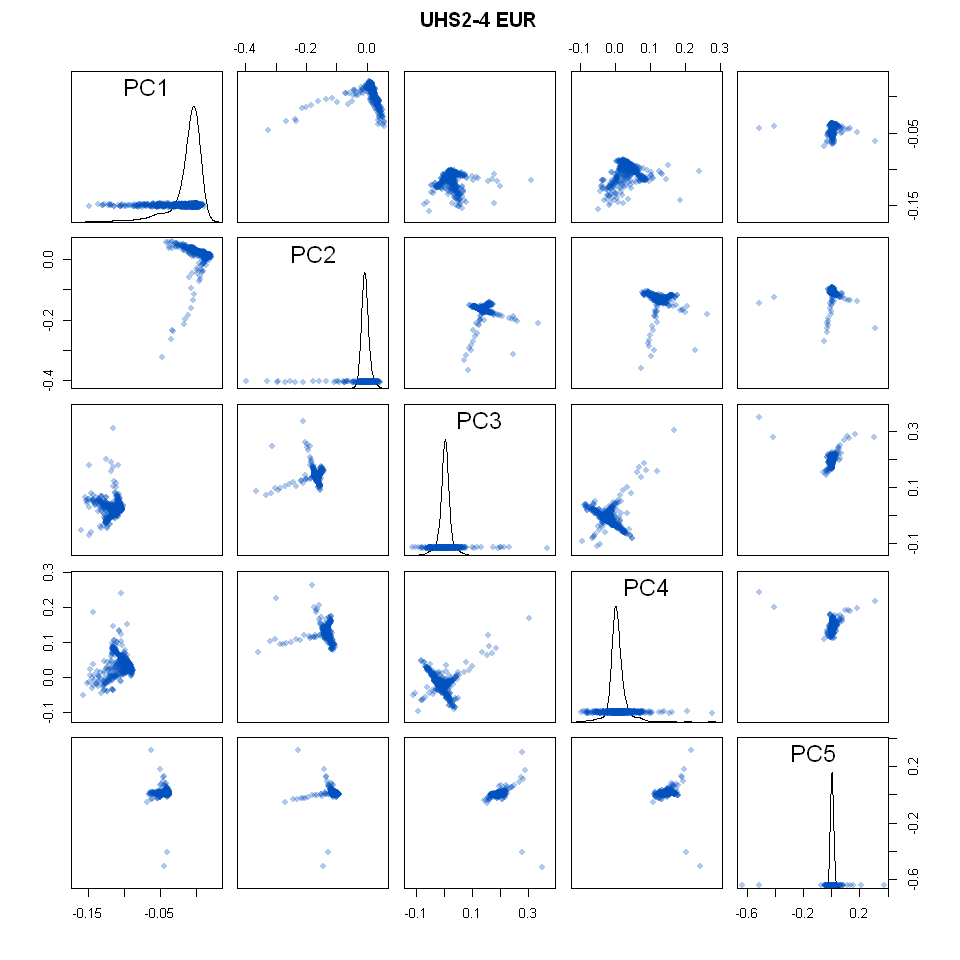

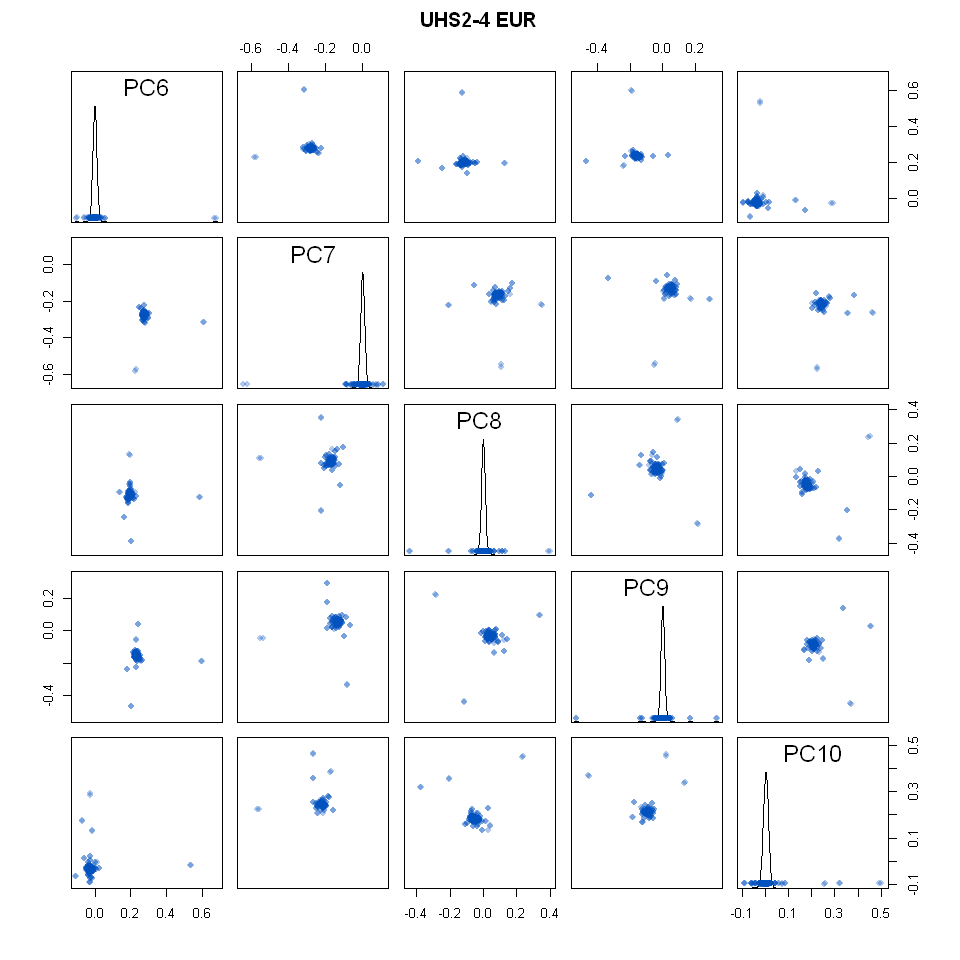

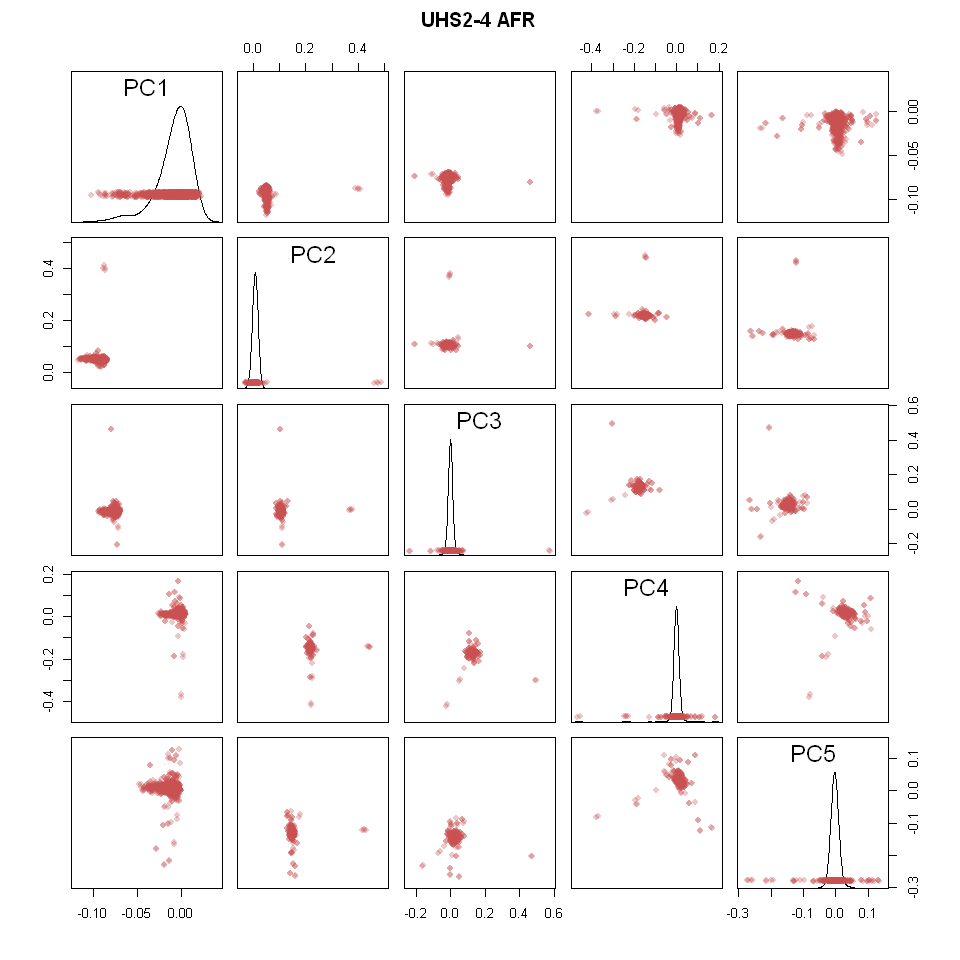

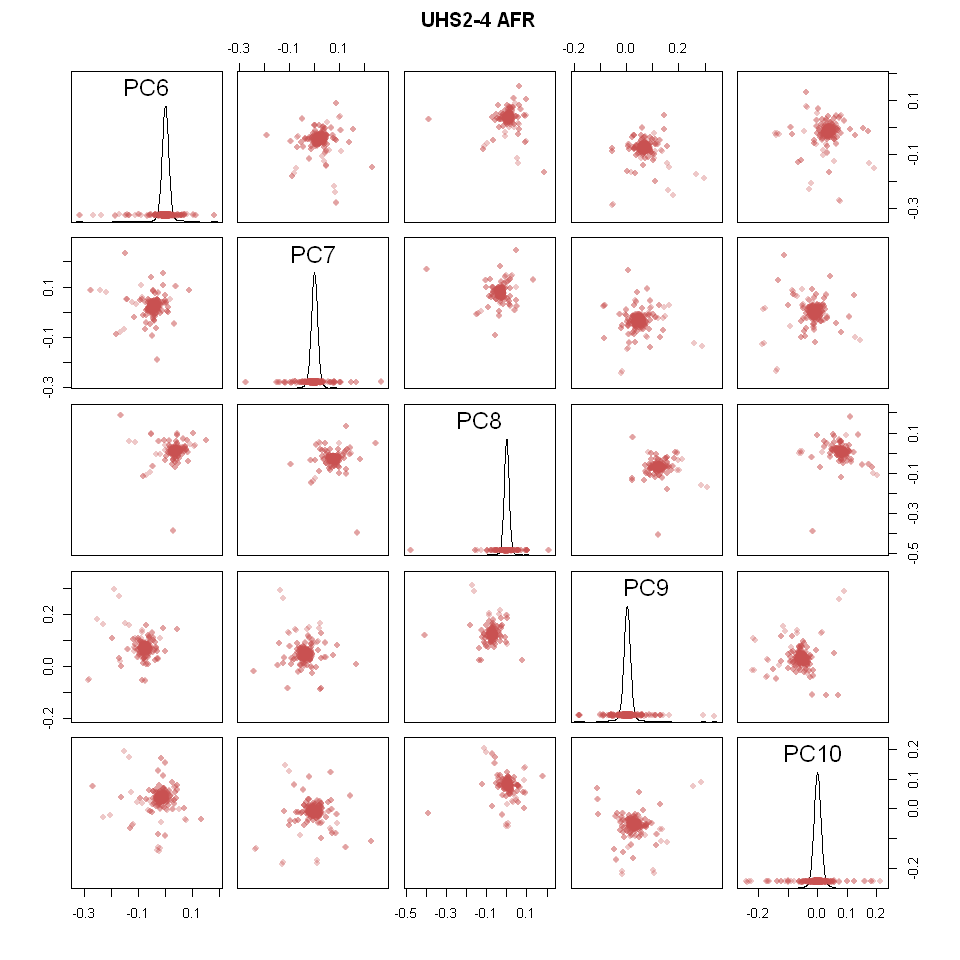

In [11]:
### View PCs ###
## R console ##
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}


## EUR ##
#Run PCA and get % variance
eur.dspace <- eur.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=eur.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS2-4 EUR", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=eur.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS2-4 EUR", cex.main=1)


## AFR ##
#Run PCA and get % variance
afr.dspace <- afr.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(200,80,80,80, maxColorValue=255) #red

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=afr.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS2-4 AFR", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=afr.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS2-4 AFR", cex.main=1)




### PC Selection
Example phenotype file.
```
IID FID sex age fou
```

In [17]:
### PC Selection ###
## R functions, DO NOT ALTER THIS CODE ##
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[2]
    
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    
    } # end function

regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

fid,iid,patid,matid,sex,fou
8000105686_HHG6940_AS95-01716,8000105686_HHG6940_AS95-01716,NA,NA,2,0.7724470661
8002019746_HHG7692_AS96-12320,8002019746_HHG7692_AS96-12320,NA,NA,2,-0.0007721273
8002019752_HHG7760_AS97-00506,8002019752_HHG7760_AS97-00506,NA,NA,2,-1.4520630037
8002019753_HHG7772_AS97-00754,8002019753_HHG7772_AS97-00754,NA,NA,2,0.0153275793
8002019755_HHG7795_AS97-01975,8002019755_HHG7795_AS97-01975,NA,NA,2,-0.5891362223
8002019756_HHG7805_AS97-02161,8002019756_HHG7805_AS97-02161,NA,NA,2,-0.0007721273


MODEL FORMULA:

 fou~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AFR group ================
Top PCs:  PC7 PC6 PC8 
PVE:      81.26

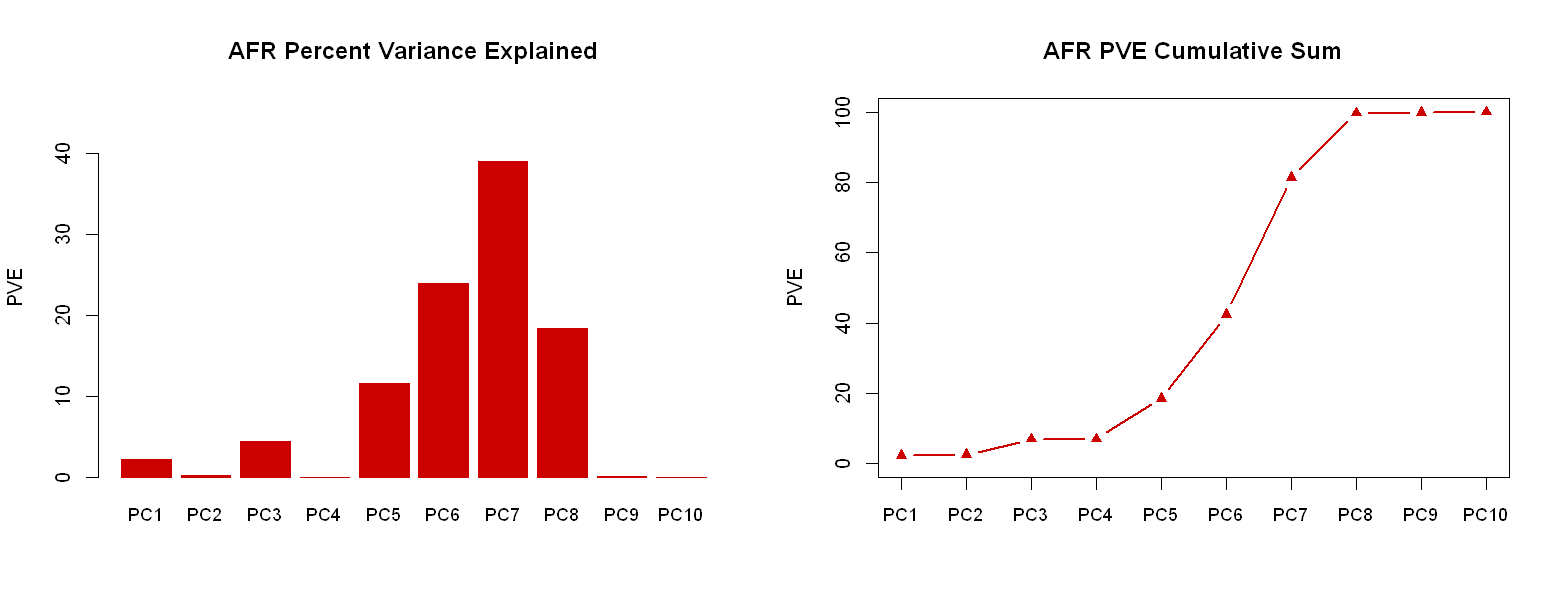

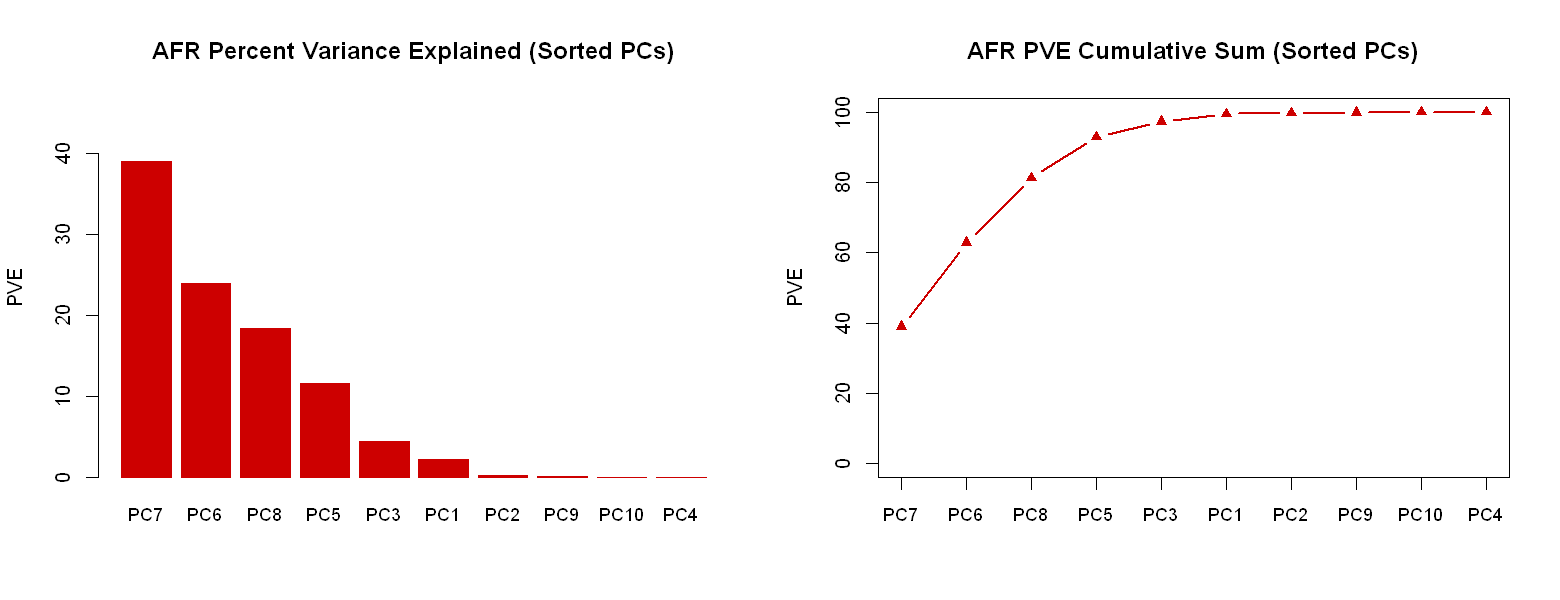

In [19]:
study <- "UHS234" # all caps
ancestry <- "AFR" # EUR or AFR

## variable information from phenotype file ($study_$an_phenotype_table.txt)
phenotype <- "fou" 
sex_var <-  "sex" 
covs <- c(sex_var, "age") # add other covariates

phen_file <- "uhs234_afr_phenotype_table_filtered.txt"
pca_file <- "afr_ld_pruned_top10_eigenvecs.txt"

model_type <- "continuous" # continuous or logistic (if log then must be coded 0 or 1)
####################################################################################################
####################################################################################################

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

fid,iid,patid,matid,sex,fou
8002019750_HHG7739_AS96-14673,8002019750_HHG7739_AS96-14673,NA,NA,2,-0.42252223
8002019754_HHG7784_AS97-01713,8002019754_HHG7784_AS97-01713,NA,NA,2,-1.79380569
8002019757_HHG7677_AS96-12253,8002019757_HHG7677_AS96-12253,NA,NA,1,-0.09319492
8002019758_HHG7694_AS96-12323,8002019758_HHG7694_AS96-12323,NA,NA,1,0.69522760
8002019761_HHG7729_AS96-13664,8002019761_HHG7729_AS96-13664,NA,NA,1,0.46673448
8002019763_HHG7750_AS96-14740,8002019763_HHG7750_AS96-14740,NA,NA,1,-0.02848753


MODEL FORMULA:

 fou~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EUR group ================
Top PCs:  PC4 PC8 PC3 
PVE:      76.21

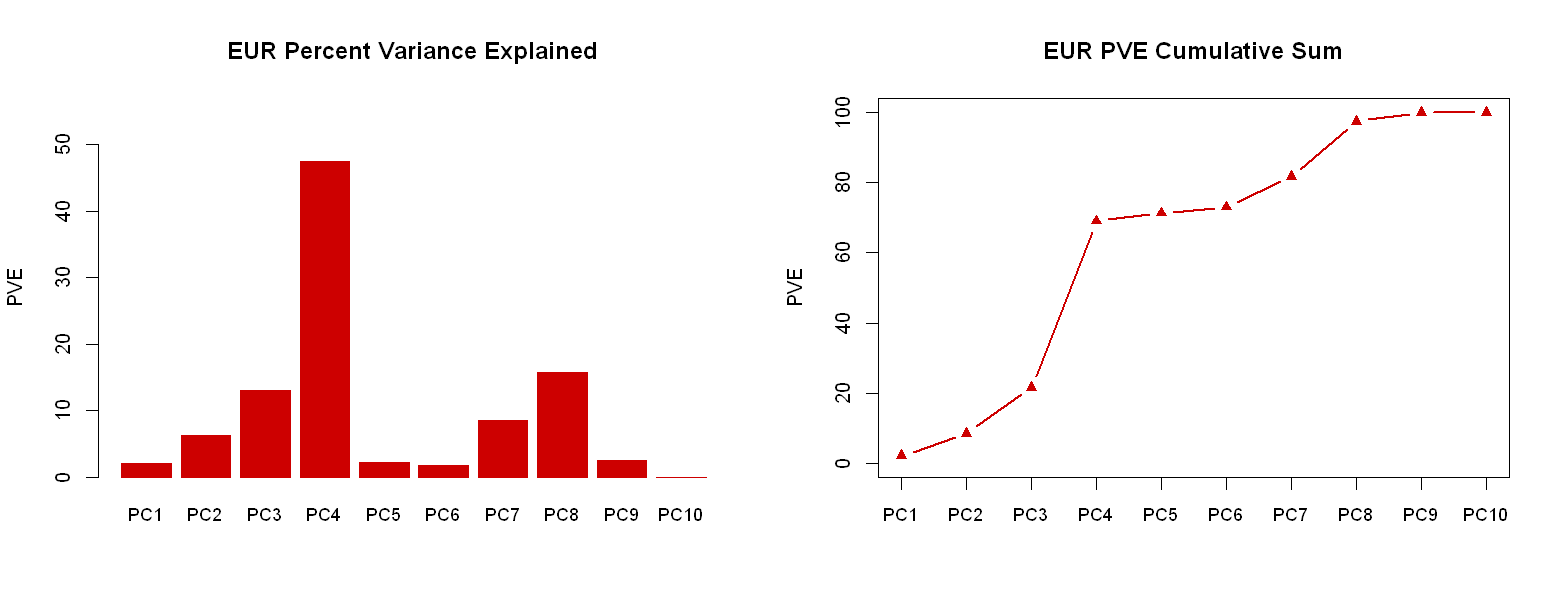

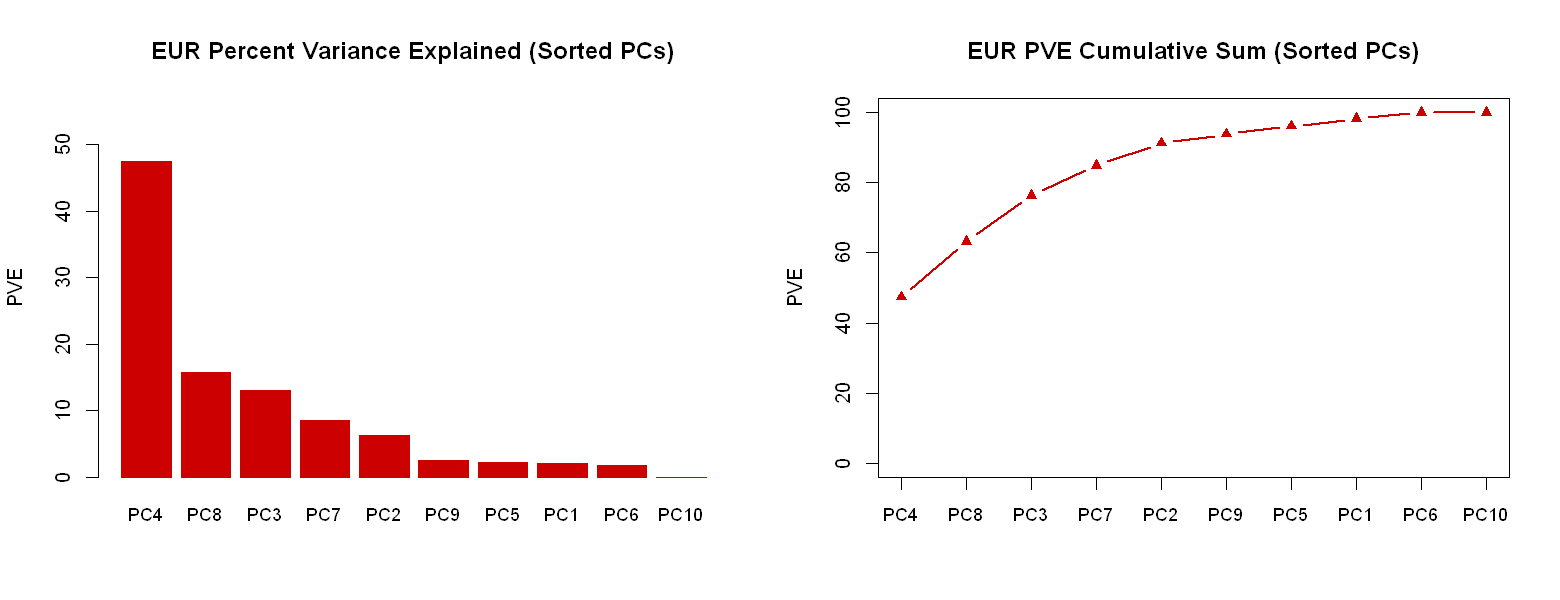

In [20]:
study <- "UHS234" # all caps
ancestry <- "EUR" # EUR or AFR

## variable information from phenotype file ($study_$an_phenotype_table.txt)
phenotype <- "fou" 
sex_var <-  "sex" 
covs <- c(sex_var, "age") # add other covariates

phen_file <- "uhs234_eur_phenotype_table_filtered.txt"
pca_file <- "eur_ld_pruned_top10_eigenvecs.txt"

model_type <- "continuous" # continuous or logistic (if log then must be coded 0 or 1)
####################################################################################################
####################################################################################################

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
## Bash ##
study="UHS234"

## EUR
awk '{OFS="_"} { print $2,$2 } ' ${study}_EUR_phen.ped > new_id
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]; $1=map[FNR]} { print $0}' \
    new_id ${study}_EUR_phen.ped > ${study}_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]; $1=map[FNR] } {print $0}' \
    new_id ${study}_EUR_cov.ped > ${study}_NGCW1_EUR_cov.ped

## AFR
awk '{OFS="_"} { print $2,$2 } ' ${study}_AFR_phen.ped > new_id
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]; $1=map[FNR]} { print $0}' \
    new_id ${study}_AFR_phen.ped > ${study}_NGCW1_AFR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]; $1=map[FNR] } {print $0}' \
    new_id ${study}_AFR_cov.ped > ${study}_NGCW1_AFR_cov.ped


## upload to EC2
$ scp -i /home/jmarks/.ssh/gwas_rsa *NGC* ec2-user@34.195.174.206:/shared/jmarks/heroin/uhs2-4/phenotype/final

### Create ProbABEL phenotype file
Only need to run this code if ProbABEL is going to be used for the final GWAS.

In [1]:
### Convert your phenotype PED files (as is required for rvtests) to the ProbABEL format ###
## R function, DO NOT ALTER THIS CODE ##
probabel_phenotype <- function(cov_file, pheno_file, study, pop, pcs, other_covs, pheno){
    
    pc_paste <- paste(pcs, collapse="_")
    othercov_paste <- paste(other_covs, collapse="_")
    out_name <- paste(study, pop, pheno, othercov_paste, pc_paste, sep="_")
    out_name <- paste0(out_name, ".txt")

    all_covs <- c(other_covs, pcs)

    # read in data files
    my_cov <- read.table(cov_file, header=T)
    my_pheno <- read.table(pheno_file, header=T)

    num.subjects <- length(my_cov[,1])

    # create new phenotype file (dataframe)
    num_cols = 2 + length(other_covs) # iid + pheno + covs
    covar.data <- data.frame(matrix(ncol = num_cols, nrow = num.subjects))
    names(covar.data) <- c("iid", pheno, other_covs)
    covar.data[1] <- paste(my_pheno$fid, my_pheno$iid, sep = "_")
    covar.data[2] <- my_pheno[, pheno]

    for (cov in all_covs){
        covar.data[, cov] <- my_cov[,cov]
    }

    write.table(x = covar.data, file = out_name, quote = F, row.names = F)
    write.table(x = covar.data[,1], file = paste0("phenotype_ids_", pop), 
                quote = F, row.names = F, col.names=F)
}

In [3]:
#### EA
#cov_file   <- "CFAR_COGA_EUR_cov.ped"  # name of the input file
#pheno_file <- "CFAR_COGA_EUR_phen.ped" # name of the input file
#study <- "cfar_coga" # lowercase
#pop <- "ea" # ea or aa
##pcs = c("PC1", "PC3", "PC7")
#pcs = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
#other_covs <- c("age", "sex", "alcohol") # field names in header of cov file
#pheno <- "hiv" # field names in header of phen file
#probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)

## Run GWAS
Autosomes for now.
### AFR

In [ ]:
# Command line # 
study="UHS234" # should match exactly study_name (e.g. capitalized) in phenotype file
ancestry="afr"
covars="age,sex,PC7,PC6,PC8"
#covars="age,sex,PC4,PC8,PC3"
version=001
ngc="fou"  # fou, oaall, or oaexp
phenotype="fou" # name in phenotype file
baseD=/shared/jmarks/heroin/uhs2-4
genD=$baseD/genotype/imputed/final
procD=$baseD/gwas/$ancestry/$version
phenD=$baseD/phenotype/final

mkdir -p $procD/final
for chr in {1..22};do
    mkdir -p $procD/processing/chr$chr
done

#####################################################################################
# Run RVtest for autosomes
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.${ancestry}_${chr}_rvtest \
        --script_prefix $procD/processing/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 3 \
        --priority 0 \
            --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/$ancestry/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${ancestry^^}_phen.ped \
            --pheno-name $phenotype \
            --covar $phenD/${study}_NGCW1_${ancestry^^}_cov.ped \
            --covar-name $covars \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/processing/chr$chr/$study.${ancestry^^}.1000G.$ngc.chr$chr
done


### EUR

In [ ]:
# Command line # 
study="UHS234" # should match exactly study_name (e.g. capitalized) in phenotype file
ancestry="eur"
covars="age,sex,PC4,PC8,PC3"
version=001
ngc="fou"  # fou, oaall, or oaexp
phenotype="fou" # name in phenotype file
baseD=/shared/jmarks/heroin/uhs2-4
genD=$baseD/genotype/imputed/final/
procD=$baseD/gwas/$ancestry/$version
phenD=$baseD/phenotype/final

mkdir -p $procD/final
for chr in {1..22};do
    mkdir -p $procD/processing/chr$chr
done

#####################################################################################
    # Run RVtest for autosomes
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.${ancestry}_${chr}_rvtest \
        --script_prefix $procD/processing/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 3 \
        --priority 0 \
            --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/$ancestry/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${ancestry^^}_phen.ped \
            --pheno-name $phenotype \
            --covar $phenD/${study}_NGCW1_${ancestry^^}_cov.ped \
            --covar-name $covars \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/processing/chr$chr/$study.${ancestry^^}.1000G.$ngc.chr$chr
done


## Results Processing
### Convert Markername to 1KG phase3 ID

In [ ]:
# Remove extra headers and add ID column
# note that the header length that needs to be skipped varies
for ancestry in {afr,eur}; do
    for (( chr=1; chr<23; chr++ )); do
      inFile=$baseD/gwas/$ancestry/001/processing/chr$chr/$study.${ancestry^^}.1000G.$ngc.chr$chr.MetaScore.assoc.gz
      outFile=$baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.${ancestry}.1000G.$ngc.chr$chr.txt
      echo Processing $inFile
      gunzip -c $inFile | perl -lane '
        if (!/^##/){
        print "ID\t".$_;
        }' > $outFile
    done &
done

In [ ]:
# convert IDs to 1000G_p3
for ancestry in {afr,eur}; do
    for chr in {1..22};do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${study,,}.1000g_p3_chr${chr}.$ancestry \
            --script_prefix $baseD/gwas/$ancestry/001/processing/chr$chr/name_conversion \
            --mem 13 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
              --file_in $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G.$ngc.chr$chr.txt \
              --file_out $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.txt \
              --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
              --file_in_header 1 \
              --file_in_id_col  0 \
              --file_in_chr_col  1 \
              --file_in_pos_col  2 \
              --file_in_a1_col  3 \
              --file_in_a2_col  4 \
              --chr $chr
    done
done


### MAF and RSQ filters
Filter variants that have MAF <= 0.01 and r^2 <= 0.3.

In [ ]:
## Filter by MAF>0.01 in study and RSQ>0.3 ##
for ancestry in {afr,eur}; do
    for chr in {1..22}; do
        echo -e "${ancestry} chr${chr}..."
        zcat $genD/$ancestry/chr${chr}.info.gz | \
            tail -n +2 | \
            awk '{ if($5 > 0.01 && $7 > 0.3){ print $1 } }' \
            > $baseD/gwas/$ancestry/001/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep

            # apply filter
            head -1 $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.txt >\
                $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt
            

            awk 'NR==FNR{ map[$1]=1; next } { if ($2":"$3":"$4":"$5 in map) {print $0 } } ' \
            $baseD/gwas/$ancestry/001/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
            $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.txt \
            >> $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt
    done &
done 

## Filter by MAF > 0.01 in 1000G
for ancestry in {afr,eur}; do
    for chr in {1..22}; do
        head -1 $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt >\
            $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study_${ancestry}.txt

        awk 'NR==FNR{ map[$1]=1; next} $1 in map {print $0}' \
            /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${ancestry} \
            $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt >>\
            $baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study_${ancestry}.txt
    done &
done 

### Manhattan and QQ plots

In [ ]:
# Make results table
for ancestry in {afr,eur}; do
    outfile=$baseD/gwas/$ancestry/001/processing/${study,,}.${ancestry}.1000G.$ngc.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    
    for chr in {1..22}; do
        infile=$baseD/gwas/$ancestry/001/processing/chr$chr/${study,,}.$ancestry.1000G_p3.$ngc.chr$chr.rsq.maf_study_${ancestry,,}.txt
        echo "Processing ${infile}"
        tail -n +2 ${infile} | \
            perl -lane 'if (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T") && (($F[4] eq "A" || $F[4] eq "C" || $F[4] eq "G" || $F[4] eq "T"))) {
                            print join("\t",$F[0],$F[1],$F[2],$F[16],"snp");
                        } else {
                            print join("\t",$F[0],$F[1],$F[2],$F[16],"indel");
                        }' >> $outfile
    done &
done 

    # Make Q-Q and manhattan plots
for ancestry in {afr,eur}; do
   /shared/bioinformatics/software/scripts/qsub_job.sh \
       --job_name $study.$ancestry.gwas_plots \
       --script_prefix $baseD/gwas/$ancestry/001/processing/${study,,}.${ancestry}.1000G_p3.$ngc.assoc.plot \
       --mem 25 \
       --nslots 3 \
       --priority 0 \
       --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
          --in $baseD/gwas/$ancestry/001/processing/${study,,}.${ancestry}.1000G.$ngc.assoc.table \
          --in_chromosomes autosomal_nonPAR \
          --in_header \
          --out $baseD/gwas/$ancestry/001/final/${study,,}.${ancestry}.1000G.$ngc.assoc.plot \
          --col_id VARIANT_ID \
          --col_chromosome CHR \
          --col_position POSITION \
          --col_p P \
          --col_variant_type TYPE \
          --generate_snp_indel_manhattan_plot \
          --manhattan_odd_chr_color red3 \
          --manhattan_even_chr_color dodgerblue3 \
          --manhattan_points_cex 1.5 \
          --generate_snp_indel_qq_plot \
          --qq_lines \
          --qq_points_bg black \
          --qq_lambda
done

In [ ]:
## move final stats files to final directory
cd /shared/jmarks/heroin/uhs2-4/gwas/eur/001/processing/
gzip -r * &

for chr in {1..22}; do
    mv chr$chr/uhs234.eur.1000G_p3.fou.chr$chr.rsq.maf_study_eur.txt.gz \
    ../final
done


cd /shared/jmarks/heroin/uhs2-4/gwas/afr/001/processing/
gzip -r * &

for chr in {1..22}; do
    mv chr$chr/uhs234.afr.1000G_p3.fou.chr$chr.rsq.maf_study_afr.txt.gz \
    ../final
done

## S3 upload

In [ ]:
#upload to 
s3://rti-heroin/gwas/uhs234/results/{eur,afr}